In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from time import time
import scipy.stats as stats
from scipy.stats import beta
from functools import reduce
from operator import matmul 

In [2]:
def softmax(r):
# Define a softmax function.
    exp_r = np.exp(r - np.max(r))
    return exp_r / np.sum(exp_r)

def gradient_ascent_dynamics(G, n, eta=1.0, max_iter=50_000, T_max=10): 
# The following function implements a (softmax) gradient ascent algorithm for a 3-player game with n actions.
# It takes the number of actions n, a correlation parameter lam, a learning rate eta, a max iteration count,
# and a tolerance for convergence as inputs. It returns the average payoff, the number of iterations,
# and the final payoff for player 0.    
    t_0 = time()
    # Initialise each player's "logit" vector (which will be mapped to a mixed strategy via softmax).
    r0 = np.zeros(n)
    r1 = np.zeros(n)
    r2 = np.zeros(n)
    
    total_payoff = 0.0
    
    for it in range(max_iter):
        # Convert logits to mixed strategies.
        p0 = softmax(r0)
        p1 = softmax(r1)
        p2 = softmax(r2)

        
        # Compute the expected payoff for each pure action for each player.
        # For player 0: Q0[i] = sum_{j,k} p1[j] p2[k] G[0][i, j, k]
        Q0 = np.array([np.dot(p1, np.dot(G[0][i, :n, :n], p2)) for i in range(n)])
        # For player 1: Q1[i] = sum_{j,k} p0[j] p2[k] G[1][j, i, k]
        Q1 = np.array([np.dot(p0, np.dot(G[1][:n, i, :n], p2)) for i in range(n)])
        # For player 2: Q2[i] = sum_{j,k} p0[j] p1[k] G[2][j, k, i]
        Q2 = np.array([np.dot(p0, np.dot(G[2][:n, :n, i], p1)) for i in range(n)])
        
        # Compute the overall expected payoff for each player.
        f0 = np.dot(p0, Q0)
        f1 = np.dot(p1, Q1)
        f2 = np.dot(p2, Q2)
        
        # Accumulate payoff for averaging.
        total_payoff += f0

        # Every 100 iterations, check if the current strategy profile is an epsilon-NE.
        if it % 100 == 0:
            best0 = np.max(Q0)
            best1 = np.max(Q1)
            best2 = np.max(Q2)
            if ((f0 >= 0.99 * best0) and (f1 >= 0.99 * best1) and (f2 >= 0.99 * best2)) or (time()-t_0 > T_max):
                break


        grad_r0 = Q0 - f0
        grad_r1 = Q1 - f1
        grad_r2 = Q2 - f2
        
        # Update the logits using a simple gradient ascent step.
        r0 += eta * grad_r0 
        r1 += eta * grad_r1 
        r2 += eta * grad_r2 
    
    avg_payoff = total_payoff / it
    return it, avg_payoff, f0


# Hyperparameters for gradient ascent. These numbers have been selected after some trial and error, and provided the best results for this algorithm.
step_size = 1.0
max_iterations = 50_000

## Utility functions (please skip to the next section)
These are utility function only used to plot

In [3]:
def clopper_pearson_interval(k, n, alpha=0.005):
    lower = beta.ppf(alpha / 2, k, n - k + 1) if k > 0 else 0.0
    upper = beta.ppf(1 - alpha / 2, k + 1, n - k) if k < n else 1.0
    return lower, upper

def plot_single_algorithm(alg_name="SBRD", varName="time", ylabel=None, axis=0, mean_name=None, variance=True, only_if_conv=False, log=False, n_cols=1, number_of_plots=-1, binomial=False, isPositive=False, width=6, legend_loc = "upper left", title=None):
    """
    Plot runtimes of a single algorithm (PGD or SBRD) in subplots, comparing across one parameter.

    Parameters:
    - alg_name: 'PGD' or 'SBRD'
    - varName: variable name suffix for accessing data (e.g., "Seconds" accesses PGD_Seconds or SBRD_Seconds)
    - axis: 0 or 1
        - 0: compare across N for each Lambda (row-wise)
        - 1: compare across Lambda for each N (column-wise)
    - variance: whether to include standard deviation shading
    - only_if_conv: whether to only include data when convergence was achieved (using *_isNash)
    - log: whether to plot on a log scale
    - n_cols: number of columns of subplots to create
    - number_of_plots: number of subplots to show (-1 for all)
    - lambda_vals: optional list/array of Lambda values
    - A_vals: optional list/array of N values
    - binomial: whether the data is binomial (0-1 values)
    """

    if ylabel == None:
        ylabel = varName

    # If the function input "only_if_conv" is True, only include the cases in which the samples for which algorithm converges
    data = globals()[f"{alg_name}_{varName}"]
    if only_if_conv:
        isNash = globals()[f"{alg_name}_isNash"]
        masked_data = np.where(isNash, data, np.nan)
    else:
        masked_data = data

    """
    Creates the matrix of means and the matrices needed for the Confidence Intervals.
    If the data is Binary, the CI is done using the Clopper Pearson interval. If the data is real, we use the Standard Error
    """

    mean_data = np.nanmean(masked_data, axis=-1)
    if variance:
        n_data = np.sum(~np.isnan(masked_data), axis=-1)
        if binomial:
            sum_data = np.nansum(masked_data, axis=-1)
            lower_bounds = np.zeros_like(mean_data)
            upper_bounds = np.ones_like(mean_data)
            for i in range(mean_data.shape[0]):
                for j in range(mean_data.shape[1]):
                    if n_data[i, j] > 0:
                        lower, upper = clopper_pearson_interval(int(sum_data[i, j]), int(n_data[i, j]))
                        lower_bounds[i, j] = lower
                        upper_bounds[i, j] = upper
        else:
            SE_data = np.sqrt(np.divide(np.nanvar(masked_data, axis=-1), n_data))

    L, N = mean_data.shape

    """ 
    Depending on wether we want the plots to be done along the 0 or 1 axis, we get different "get_mean", "get_lower" and "get_upper"
    functions, that take as input i and return the right vector (respectively the mean, lower and upper CI points) with that index.
    """
    if axis == 0:
        num_plots = L
        x_vals = A_vals 
        y_vals = lambda_vals 
        get_mean = lambda i: mean_data[i, :]
        if variance:
            if binomial:
                get_lower = lambda i: lower_bounds[i, :]
                get_upper = lambda i: upper_bounds[i, :]
            else:
                get_var = lambda i: SE_data[i, :]
        label = "Correlation λ"
        xlabel = "Nr. actions"
    elif axis == 1:
        num_plots = N
        x_vals = lambda_vals
        y_vals = A_vals 
        get_mean = lambda i: mean_data[:, i]
        if variance:
            if binomial:
                get_lower = lambda i: lower_bounds[:, i]
                get_upper = lambda i: upper_bounds[:, i]
            else:
                get_var = lambda i: SE_data[:, i]
        label = "Nr. actions"
        xlabel = "Correlation λ"
    else:
        raise ValueError("Axis must be 0 (over Lambda) or 1 (over N)")
    


    """
    We now create the structure for the plots
    """
    if number_of_plots == -1 or number_of_plots >= num_plots:
        indices = list(range(num_plots))
    else:
        indices = np.linspace(0, num_plots - 1, number_of_plots, dtype=int)

    n_rows = math.ceil(len(indices) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(width * n_cols, 3 * n_rows), sharex=True)
    axes = np.array(axes).flatten()

    color = (0.1, 0.5, 0.8) if alg_name == "PGD" else (0.9, 0.4, 0.2)

    """
    We finally plot the various graphs
    """

    for i, idx in enumerate(indices):
        ax = axes[i]
        ax.set_xlabel(xlabel)
        if log:
            ax.set_yscale('log')
            ydata = get_mean(idx)
            ymin = np.nanmin(ydata)
            ymax = np.nanmax(ydata)

            # Round to nearest powers of 10
            lower = 10 ** np.floor(np.log10(ymin))
            upper = 10 ** np.ceil(np.log10(ymax))
            ax.set_ylim(lower, upper)
        ax.plot(x_vals, get_mean(idx), color=color, label=mean_name if mean_name!= None else varName)
        if variance:
            if binomial:
                ax.fill_between(x_vals, get_lower(idx), get_upper(idx), color=color, alpha=0.2, label='99.5% CI')
            else:
                if isPositive:
                    lower = np.clip(get_mean(idx) - 2*get_var(idx), 0, None)
                    upper = np.clip(get_mean(idx) + 2*get_var(idx), 0, None)
                ax.fill_between(x_vals, lower, upper, color=color, alpha=0.2, label='±2 SE')
        ax.set_ylabel(ylabel)
        if title == None:
            ax.set_title(f"{label} = {round(y_vals[idx], 2)}, samples = {samples}")
        else:
            ax.set_title(title)
        ax.legend(loc=legend_loc)
        ax.grid(True)

    for j in range(len(indices), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f"{alg_name}_{varName}_samples={samples} axis={axis}.pdf")
    plt.show()



def compare_algorithms(PGD_varName="time", SBRD_varName="time", yLabel=None, axis=0, mean_1_name=None, mean_2_name=None, title=None, variance=True, only_if_conv=False, log=False, n_cols=1, number_of_plots=-1, binomial=False, width = 6, isPositive=False, legend_loc="upper left", expnr = "3"):
    """
    Plot runtimes of PGD and SBRD algorithms in subplots, comparing them across one parameter.

    Parameters:
    - PGD_varName, SBRD_varName: variable name suffix for accessing data (e.g., "time" accesses PGD_time and SBRD_time)
    - axis: 0 or 1
        - 0: compare across N for each Lambda (row-wise)
        - 1: compare across Lambda for each N (column-wise)
    - variance: whether to include standard deviation shading
    - only_if_conv: whether to only include data when convergence was achieved (using PGD_isNash, SBRD_isNash)
    - log: whether to plot on a log scale
    - n_cols: number of columns of subplots to create
    - lambda_vals: global list/array of Lambda values
    - A_vals: global list/array of N values
    - number_of_plots: number of subplots to display (equally spaced). If -1, show all.
    - binomial: whether the data is binomial (0-1)
    - isPositive: whether to clip the lower bound at 0
    """
    if yLabel == None:
        yLabel = PGD_varName

    def process_data(alg_name, varName):
        data = globals()[f"{alg_name}_{varName}"]
        if only_if_conv:
            isNash = globals()[f"{alg_name}_S{expnr}_isNash"]
            data = np.where(isNash, data, np.nan)
        mean_data = np.nanmean(data, axis=-1)
        n_data = np.sum(~np.isnan(data), axis=-1)

        if not variance:
            return mean_data, None, None

        if binomial:
            sum_data = np.nansum(data, axis=-1)
            lower_bounds = np.zeros_like(mean_data)
            upper_bounds = np.ones_like(mean_data)
            for i in range(mean_data.shape[0]):
                for j in range(mean_data.shape[1]):
                    if n_data[i, j] > 0:
                        lower, upper = clopper_pearson_interval(int(sum_data[i, j]), int(n_data[i, j]))
                        lower_bounds[i, j] = lower
                        upper_bounds[i, j] = upper
            return mean_data, lower_bounds, upper_bounds
        else:
            SE = np.sqrt(np.nanvar(data, axis=-1) / n_data)
            lower_bounds = mean_data - 2 * SE
            upper_bounds = mean_data + 2 * SE
            return mean_data, lower_bounds, upper_bounds

    PGD_mean, PGD_lower, PGD_upper = process_data("PGD", PGD_varName)
    SBRD_mean, SBRD_lower, SBRD_upper = process_data("SBRD", SBRD_varName)

    L, N = PGD_mean.shape
    if axis == 0:
        num_plots = L
        x_vals = A_vals
        y_vals = lambda_vals
        get_slice = lambda data, i: data[i, :]
        label = "Correlation λ"
        xlabel = "Nr. actions"
    elif axis == 1:
        num_plots = N
        x_vals = lambda_vals
        y_vals = A_vals
        get_slice = lambda data, i: data[:, i]
        label = "Nr. actions"
        xlabel = "Correlation λ"
    else:
        raise ValueError("Axis must be 0 (over Lambda) or 1 (over N)")

    indices = range(num_plots) if number_of_plots == -1 or number_of_plots >= num_plots else np.linspace(0, num_plots - 1, number_of_plots, dtype=int)
    n_rows = math.ceil(len(indices) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(width * n_cols, 3 * n_rows), sharex=True)
    axes = np.array(axes).flatten()

    colors = {"PGD": (0.1, 0.5, 0.8), "SBRD": (0.9, 0.4, 0.2)}

    for i, idx in enumerate(indices):
        ax = axes[i]
        ax.set_xlabel(xlabel)
        if log:
            ax.set_yscale('log')

        for name, mean, lower, upper, color in [
            ("PGD", PGD_mean, PGD_lower, PGD_upper, colors["PGD"]),
            ("SBRD", SBRD_mean, SBRD_lower, SBRD_upper, colors["SBRD"])
        ]:
            y = get_slice(mean, idx)
            if variance:
                if binomial:
                    if name == "PGD":
                        curr_label = mean_1_name
                    if name == "SBRD":
                        curr_label = mean_2_name
                else:
                    if name == "PGD":
                        curr_label = mean_1_name
                    if name == "SBRD":
                        curr_label = mean_2_name
            ax.plot(x_vals, y, label=curr_label, color=color)
            if variance and lower is not None and upper is not None:
                y_lower = get_slice(lower, idx)
                y_upper = get_slice(upper, idx)
                if isPositive:
                    y_lower = np.clip(y_lower, 0, None)
                    y_upper = np.clip(y_upper, 0, None)
                #label_ci = "99.5% CI" if binomial else "±2SE"
                ax.fill_between(x_vals, y_lower, y_upper, color=color, alpha=0.2)#, label=f"{label_ci}")

        ax.set_ylabel(yLabel)
        if title == None:
            ax.set_title(f"{label} = {round(y_vals[idx], 2)}, samples = {samples}")
        else:
            ax.set_title(title)
        ax.legend(loc= legend_loc)
        ax.grid(True)

    for j in range(len(indices), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f"compare_{PGD_varName}_axis={axis}.pdf")
    plt.show()

## Dynamics definitions

In [4]:
def generate_reward_matrix(P, A, lam):
    """
    Generate the reward matrix for an P-player A-actions game 

    Parameters:
    - N (int): Number of actions per player.
    - lam (float): Correlation between players' payoffs.

    Returns:
    - np.ndarray: Reward tensor G of shape (3, N, N, N). Each entry G[i, a, b, c]
      is the payoff for player i when players 1, 2, 3 play actions a, b, c respectively.
    """
    # Correlation matrix across players
    diagonal = np.diag(np.ones(P))
    ones_matrix = np.ones((P, P))
    corr_matrix = (ones_matrix-np.diag(np.diag(ones_matrix)))*lam+diagonal
    
    # Cholesky decomposition for generating correlated normal variables
    L = np.linalg.cholesky(corr_matrix)
    
    # Generate correlated payoffs for all joint action profiles
    raw_samples = np.random.randn(P, A**P)
    correlated = L @ raw_samples
    
    shape = tuple(P if i==0 else A for i in range(P+1))

    # Reshape to (3, N, N, N): one payoff matrix per player
    return correlated.reshape(shape)


In [5]:
def best_response_dynamics(G, A=None):
    """
    Simulate Best Response Dynamics (SBRD) in a 3-player game.

    Parameters:
    - G (np.ndarray): Reward tensor of shape (3, N, N, N). G[i, a, b, c] gives the payoff
      to player i when players 0, 1, 2 choose actions a, b, c respectively.

    Returns:
    - cycle_length (int): Length of the cycle detected by SBRD.
    - total_steps (int): Total number of steps before entering the cycle.
    - final_payoff (float): Average payoff for player 0 over the detected cycle.
    """
    P = G.shape[0]
    if A == None:
        A = G.shape[1]

    x = tuple(0 for _ in range(P))        # Initial strategy profile
    index = 0                             # Step counter
    history = dict()                      # Maps strategy profiles to step indices

    while True:
        index += 1

        # Best responses given others' actions
        x = tuple( np.argmax( G[ tuple(i if j == 0 else x[j-1] if j-1 != i else slice(0, A) for j in range(P+1)) ] ) for i in range(P))


        if x in history:
            cycle_length = index - history[x]

            if cycle_length == 1:
                # Nash Equilibria
                return cycle_length, index, G[tuple(0 if i == 0 else x[i-1] for i in range(P+1))]

            # General cycle detected: compute average payoff for player 0
            cycle = [x]
            avg = G[tuple(0 if i == 0 else x[i-1] for i in range(P+1))]

            for _ in range(cycle_length - 1):
                x = tuple( np.argmax( G[ tuple(i if j == 0 else x[j-1] if j-1 != i else slice(0, A) for j in range(P+1)) ] ) for i in range(P))
                cycle.append(x)
                avg += G[tuple(0 if i == 0 else x[i-1] for i in range(P+1))]

            return cycle_length, index, avg / cycle_length

        # Log the current profile and continue
        history[x] = index


In [6]:
def softmax(r):
# Define a softmax function.
    exp_r = np.exp(r - np.max(r))
    return exp_r / np.sum(exp_r)


In [7]:
def new_SPGD(G, eta=1.0, max_iter=50_000, T_max=10): 
# The following function implements a (softmax) gradient ascent algorithm for a 3-player game with n actions.
# It takes the number of actions n, a correlation parameter lam, a learning rate eta, a max iteration count,
# and a tolerance for convergence as inputs. It returns the average payoff, the number of iterations,
# and the final payoff for player 0.    
    t_0 = time()
    # Initialise each player's "logit" vector (which will be mapped to a mixed strategy via softmax).
    P, A = G.shape[0:2]

    R = tuple(np.zeros(A) for _ in range(P))
    
    total_payoff = 0.0
    n=A
    p=[3 for i in range(P)]
    for it in range(max_iter):
        # Convert logits to mixed strategies.
        Softmax = tuple(softmax(R[i]) for i in range(P))
        
        # Compute the expected payoff for each pure action for each player.
        # For player 0: Q0[i] = sum_{j,k} p1[j] p2[k] G[0][i, j, k]
  
        Q = tuple(                       # Q[0], …, Q[P-1]
            np.array([               #   each is an (A, …, A) tensor
                np.take(G[p], i, axis=p)              # fix the i-th action of player p
                @ reduce(matmul,                     # multiply all the other Softmax mats
                        (Softmax[j] for j in range(P) if j != p))
            for i in range(A)])
        for p in range(P))


        # For player 1: Q1[i] = sum_{j,k} p0[j] p2[k] G[1][j, i, k]
        
        # Compute the overall expected payoff for each player.
        F = tuple(np.dot(Softmax[i], Q[i]) for i in range(P))
        
        # Accumulate payoff for averaging.
        total_payoff += F[0]

        # Every 100 iterations, check if the current strategy profile is an epsilon-NE.
        if it % 100 == 0:
            best = tuple(np.max(Q[i]) for i in range(P))
            if (min(best)>0.99) or (time()-t_0 > T_max):
                break


        grad = tuple(Q[i]-F[i] for i in range(P))
        
        # Update the logits using a simple gradient ascent step.
        R = tuple(R[i]+eta*grad[i] for i in range(P))
    
    avg_payoff = total_payoff / it
    return it, avg_payoff, F[0]

# Main Results

## Section 1. Finding: 2-player random potential games converge fast to a two-cycle


Setting of the experiment:
- 10000 independent simulations
- Each simulation takes lambda in a range of values between 0 and 1
- The number of actions is set to 50
- The number of players is set to two

Statistics analysed:
- SBRD_S1_twoCycles[l, 0, t]: True if the t-th test with the l-th value of lambda converges to a 2-cycle
- SBRD_S1_nrSteps[l, 0, t]: number of steps to convergence (or cycle) of the t-th test with the l-th value of lambda

In [8]:
# Number of simulations per (λ, N) setting
samples = 10_000
lambda_vals = [0.09999999999*0.5*i for i in range(21)]
A_vals = [50]

SBRD_S1_twoCycles = np.full((len(lambda_vals), 1, samples), False, dtype=bool)
SBRD_S1_nrSteps = np.zeros((len(lambda_vals), len(A_vals), samples))

We now run the experiment, setting the numpy random seed to 2025. We print the time it takes to run the whole experiment in seconds.

In [9]:
np.random.seed(2025) #We set the random seed for reproducibility 
T_0 = time()  # Start timer for entire experiment
max_A = max(A_vals)
for count_lam, lam in enumerate(lambda_vals):  # Loop over each lambda value
    for i in range(samples):  # Repeat experiment for statistical robustness
        G = generate_reward_matrix(2, max_A, lam)  # Generate a payoff matrix with max_n actions and correlation lambda
    
        for count_A, A in enumerate(A_vals):  # Now restrict to smaller N if needed
            # Run Best Response Dynamics and time it
            SBRD_len, SBRD_it, SBRD_val_curr = best_response_dynamics(G, A)
            SBRD_S1_twoCycles[count_lam, count_A, i] = (SBRD_len == 2)
            SBRD_S1_nrSteps[count_lam, count_A, i] = SBRD_it

# Final time report
Total_time = time() - T_0
print(Total_time)

23.52963089942932


We now begin to plot our results. The first plot represents the probability of SBRD to converge to a 2-cycle. It is plotted with a 99.5% Clopper-Pearson CI. 

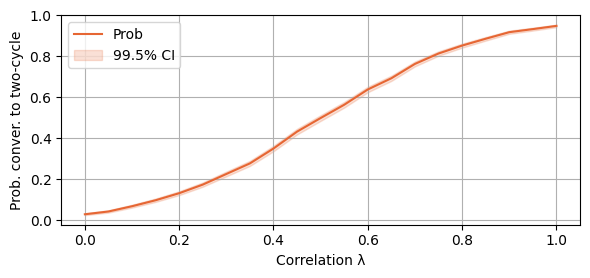

In [10]:
plot_single_algorithm(alg_name="SBRD", varName="S1_twoCycles", title="", mean_name="Prob", ylabel="Prob. conver. to two-cycle", axis=1, binomial=True, legend_loc="upper left")

The second plot represents the average number of steps before convergence. It is plotted with a 2SE interval around the mean.

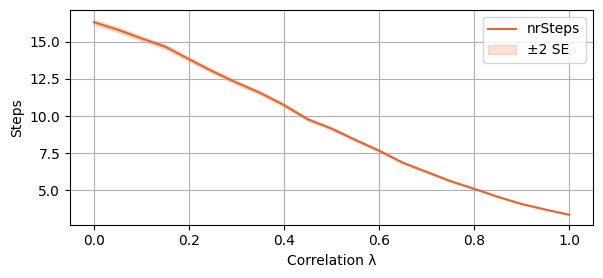

In [11]:
plot_single_algorithm(alg_name="SBRD", varName="S1_nrSteps", mean_name="nrSteps", title="", ylabel="Steps", axis=1, isPositive=True, log=False, legend_loc="upper right")

With the following script, we investigate the thresholds of lambda for which the probability of SBRD to converge to a 2-cycle surpasses 50% and 90% respectively. Which is, we find that if lambda is at least 0.55, then the probability of SBRD to converge to a 2-cycle is at least 50%. If lambda is at least 0.9, the probability is at least 90%.

In [12]:
print(round(lambda_vals[int(np.argmax(np.mean(SBRD_S1_twoCycles, axis=-1)>0.5))],2))
print(round(lambda_vals[int(np.argmax(np.mean(SBRD_S1_twoCycles, axis=-1)>0.9))],2))

0.55
0.9


## Section 2. Finding: 3-player random potential games converge fast to a NE

We now consider the setting with three players.
Setting of the experiment:
- 10000 independent simulations
- Each simulation takes lambda in a range of values between 0 and 1
- The number of actions is set to 50
- The number of players is set to three

Statistics analysed:
- SBRD_S2_isNash[l, 0, t]: True if the t-th test with the l-th value of lambda converges to a NE
- SBRD_S2_nrSteps[l, 0, t]: number of steps to convergence (or cycle) of the t-th test with the l-th value of lambda

In [13]:
# Number of simulations per (λ, N) setting
samples = 10_000
lambda_vals = [0.09999999999*0.5*i for i in range(21)]
A_vals = [50]

SBRD_S2_isNash = np.full((len(lambda_vals), 1, samples), False, dtype=bool)
SBRD_S2_nrSteps = np.zeros((len(lambda_vals), len(A_vals), samples))

We now run the experiment, setting the numpy random seed to 2025. We print the time it takes to run the whole experiment in seconds.

In [14]:
np.random.seed(2025) #We set the random seed for reproducibility 
T_0 = time()  # Start timer for entire experiment
max_A = max(A_vals)
for count_lam, lam in enumerate(lambda_vals):  # Loop over each lambda value
    for i in range(samples):  # Repeat experiment for statistical robustness
        G = generate_reward_matrix(3, max_A, lam)  # Generate a payoff matrix with max_n actions and correlation lambda
    
        for count_A, A in enumerate(A_vals):  # Now restrict to smaller N if needed
            # Run Best Response Dynamics and time it
            SBRD_len, SBRD_it, SBRD_val_curr = best_response_dynamics(G, A)
            SBRD_S2_isNash[count_lam, count_A, i] = (SBRD_len == 1)
            SBRD_S2_nrSteps[count_lam, count_A, i] = SBRD_it

# Final time report
Total_time = time() - T_0
print(Total_time)

1237.7669422626495


We are now ready to plot our results.
We first plot the probability of SBRD to converge to a NE. We plot a 99.5% Clopper-Pearson CI 

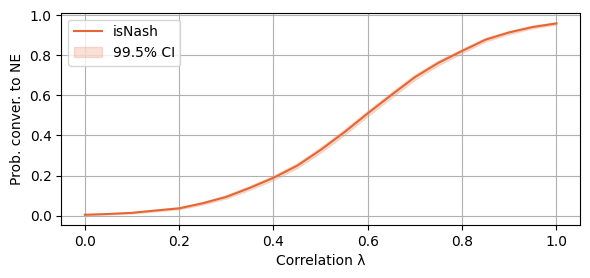

In [15]:
plot_single_algorithm(alg_name="SBRD", varName="S2_isNash", title="", mean_name="isNash", ylabel="Prob. conver. to NE", axis=1, binomial=True, legend_loc="upper left")

And then the expected number of steps before convergence (or reaching a cycle). We add a 2SE interval to the plot.

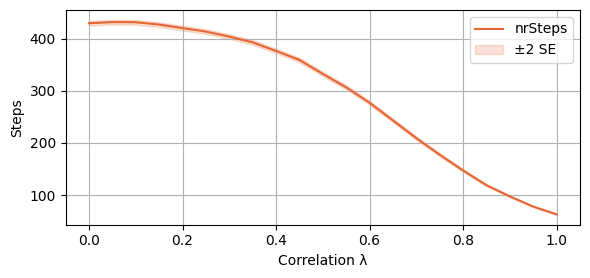

In [16]:
plot_single_algorithm(alg_name="SBRD", varName="S2_nrSteps", mean_name="nrSteps", title="", ylabel="Steps", axis=1, isPositive=True, log=False, legend_loc="upper right")

## Section 3. Finding: comparison of SBRD and SPGD in 3-player random potential games

We now compare SBRD with SPGD for 3-player games. 
Setting of the experiment:
- 1000 independent simulations
- Each simulation takes lambda in a range of values between 0.85 and 1
- The number of actions is set to 50
- The number of players is set to three

Statistics analysed:
- For SPGD:
    - PGD_S3_isNash[l, 0, t]: True if for the t-th test with the l-th value of lambda, SPGD converges to a NE
    - PGD_S3_numIte[l, 0, t]: number of steps to convergence (or cycle) for SPGD of the t-th test with the l-th value of lambda
    - PGD_S3_valFin[l, 0, t]: final payoff reached by SBPD in the t-th test with l-th value of lambda
    - PGD_S3_valAvg[l, 0, t]: average payoff during the trajectory of SBPD in the t-th test with the l-th value of lambda
    - PGD_S3_time[l, 0, t]: time to run SBPD in the t-th test with l-th value of lambda. 
        - Remark: SPGD is automatically stopped at the first check-point after 10 seconds run.
- for SBRD:
    - SBRD_S3_isNash[l, 0, t]: True if for the t-th test with the l-th value of lambda, SBRD converges to a NE
    - SBRD_S3_numIte[l, 0, t]: number of steps to convergence (or cycle) for SBRD of the t-th test with the l-th value of lambda
    - SBRD_S3_val[l, 0, t]: NE payoff reached by SBRD in the t-th test with l-th value of lambda if SBRD converges to a NE, or average payoff along the cycle if SBRD converges to a cycle.
    - SBRD_S3_time[l, 0, t]: time to run SBRD in the t-th test with l-th value of lambda.  

In [17]:
# Experimental setup
samples = 1000
lambda_vals = [0.85+0.09999999999*0.25*i for i in range(7)] # List of lambda values to test
A_vals = [50]

# Outputs to Track
## Policy Gradient Dynamics
PGD_S3_isNash = np.full((len(lambda_vals), len(A_vals), samples), False, dtype=bool) # {0,1} veridicity of Nash in Policy Gradient Dynamics
PGD_S3_numIte = np.zeros((len(lambda_vals), len(A_vals), samples)) # Number of iterations in Policy Gradient Dynamics
PGD_S3_valFin = np.zeros((len(lambda_vals), len(A_vals), samples)) # Final payoff for player 0 in Policy Gradient Dynamics
PGD_S3_valAvg = np.zeros((len(lambda_vals), len(A_vals), samples)) # Average payoff for player 0 in Policy Gradient Dynamics
PGD_S3_time = np.zeros((len(lambda_vals), len(A_vals), samples))   # Runtime in Policy Gradient Dynamics

## Best Response Dynamics
SBRD_S3_isNash = np.full((len(lambda_vals), len(A_vals), samples), False, dtype=bool) # {0,1} veridicity of Nash in Best Response Dynamics
SBRD_S3_numIte = np.zeros((len(lambda_vals), len(A_vals), samples)) # Number of iterations in Best Response Dynamics
SBRD_S3_val = np.zeros((len(lambda_vals), len(A_vals), samples)) # Final payoff for player 0 in Best Response Dynamics
SBRD_S3_time = np.zeros((len(lambda_vals), len(A_vals), samples))   # Runtime in Best Response Dynamics

In [18]:
max_A = A_vals[-1]  # Maximum number of actions (fixed at 50)
np.random.seed(2025) #We set the random seed for reproducibility 

T_0 = time()  # Start the global timer

for count_lam, lam in enumerate(lambda_vals):  # Loop over correlation values
    for i in range(samples):  # Loop over sample repetitions
        # Generate a shared reward matrix for both algorithms
        G = generate_reward_matrix(3, max_A, lam)

        for count_A, A in enumerate(A_vals):  # Loop over population sizes (fixed here)
            t_0 = time()  # Start timer for PGD
            PGD_it, PGD_avg_val, PGD_val = gradient_ascent_dynamics(G, A)
            t = time() - t_0  # Elapsed time

            PGD_S3_isNash[count_lam, count_A, i] = (PGD_it < 50_000 - 1)  # Converged?
            PGD_S3_numIte[count_lam, count_A, i] = PGD_it
            PGD_S3_valFin[count_lam, count_A, i] = PGD_val
            PGD_S3_valAvg[count_lam, count_A, i] = PGD_avg_val
            PGD_S3_time[count_lam, count_A, i] = t

            # === Best Response Dynamics (SBRD) ===
            t_0 = time()  # Start timer for SBRD
            SBRD_len, SBRD_it, SBRD_val_curr = best_response_dynamics(G, A)
            t = time() - t_0  # Elapsed time

            # Store SBRD results
            SBRD_S3_isNash[count_lam, count_A, i] = (SBRD_len == 1)  # Converged to pure NE?
            SBRD_S3_numIte[count_lam, count_A, i] = SBRD_it
            SBRD_S3_val[count_lam, count_A, i] = SBRD_val_curr
            SBRD_S3_time[count_lam, count_A, i] = t

# === Time Summary ===
Tot_time = time() - T_0
Tot_time_SBRD = np.sum(SBRD_S3_time)
Tot_time_PGD = np.sum(PGD_S3_time)
Tot_time_gener = Tot_time - Tot_time_SBRD - Tot_time_PGD

# Print runtime breakdown
print(f"Total time to run: {round(Tot_time, 1)} s")
print(f"Percentage of the time spent on random generation of matrix: {round((Tot_time_gener / Tot_time) * 100, 1)}%")
print(f"Percentage of the time spent on SBRD algorithm: {round((Tot_time_SBRD / Tot_time) * 100, 1)}%")
print(f"Percentage of the time spent on PGD algorithm: {round((Tot_time_PGD / Tot_time) * 100, 1)}%")


Total time to run: 5859.2 s
Percentage of the time spent on random generation of matrix: 0.6%
Percentage of the time spent on SBRD algorithm: 0.0%
Percentage of the time spent on PGD algorithm: 99.4%


Additional remark:
We print what percentage of the time each part of the experiment takes. We consistently obtain that SPGD counts for over 99% of the whole time, SBRD accounts for less than 0.1% of the running time.

We are now ready to plot our findings. We first compare the average running time of both algorithms. Note that SPGD is stopped at the first checkpoint after 10 seconds. Further notice that the scale used is logarithmic!

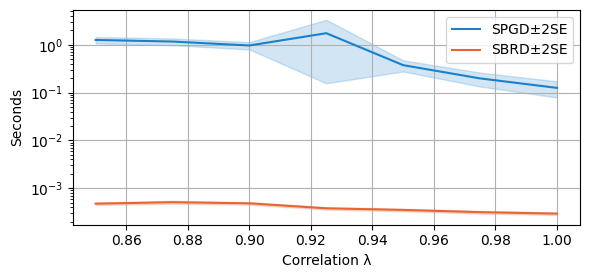

In [24]:
compare_algorithms(PGD_varName="S3_time", SBRD_varName="S3_time", title="", mean_1_name="SPGD±2SE", mean_2_name="SBRD±2SE", yLabel="Seconds", axis=1, variance=True, isPositive=True, log=True, expnr="3", legend_loc="upper right")

We now compare the final payoffs of the two algorithms. As the plotting function is called with parameter `only_if_conv=True', we only consider the cases in which both algorithms converge. Notice that this happens with probability at least 90% at these regimes of lambda for both algorithms, as analysed above.

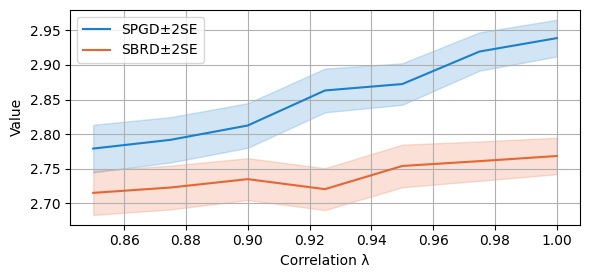

In [26]:
compare_algorithms(PGD_varName="S3_valFin", SBRD_varName="S3_val", title="", mean_1_name="SPGD±2SE", expnr="3", mean_2_name="SBRD±2SE", yLabel="Value", axis=1, variance=True, isPositive=True, only_if_conv=True, legend_loc="upper left")

We compare now the number of steps required to converge (to a NE or a cycle) for both algorithms. The scale is again logarithmic.

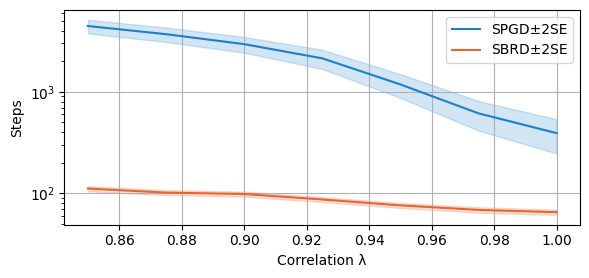

In [27]:
compare_algorithms(PGD_varName="S3_numIte", SBRD_varName="S3_numIte", title="", mean_1_name="SPGD±2SE", mean_2_name="SBRD±2SE", yLabel="Steps", axis=1, variance=True, isPositive=True, log=True, legend_loc="upper right")

We finally compare, over all the experiments (both converging and not), the average payoff of SPGD along its learning curve with the final payoff of SBRD. As described in the main paper, this makes sense as the number of steps to convergence of SBRD is much lower than the number of steps to convergence of SPGD.

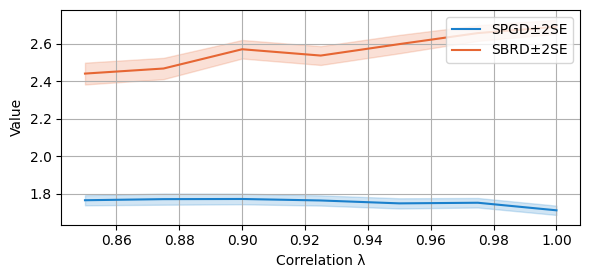

In [28]:
compare_algorithms(PGD_varName="S3_valAvg", SBRD_varName="S3_val", title="", mean_1_name="SPGD±2SE", mean_2_name="SBRD±2SE", yLabel="Value", axis=1, variance=True, isPositive=True, legend_loc="upper right")

# Appendix

## Section A. Results of Section 1. also hold for more actions

We now show that what we showed in Section 1. still holds for more actions.
Setting of the experiment:
- 1000 independent simulations
- Each simulation takes lambda in a range of values between 0 and 1
- The number of actions is set to 500
- The number of players is set to two

Statistics analysed:
- SBRD_S4_twoCycles[l, 0, t]: True if the t-th test with the l-th value of lambda converges to a 2-cycle
- SBRD_S4_nrSteps[l, 0, t]: number of steps to convergence (or cycle) of the t-th test with the l-th value of lambda

In [29]:
# Number of simulations per (λ, N) setting
samples = 1_000
lambda_vals = [0.09999999999*0.5*i for i in range(21)]
A_vals = [500]

SBRD_S4_twoCycles = np.full((len(lambda_vals), 1, samples), False, dtype=bool)
SBRD_S4_nrSteps = np.zeros((len(lambda_vals), len(A_vals), samples))

In [30]:
np.random.seed(2025) #We set the random seed for reproducibility 
T_0 = time()  # Start timer for entire experiment
max_A = max(A_vals)
for count_lam, lam in enumerate(lambda_vals):  # Loop over each lambda value
    for i in range(samples):  # Repeat experiment for statistical robustness
        G = generate_reward_matrix(2, max_A, lam)  # Generate a payoff matrix with max_n actions and correlation lambda
    
        for count_A, A in enumerate(A_vals):  # Now restrict to smaller N if needed
            # Run Best Response Dynamics and time it
            SBRD_len, SBRD_it, SBRD_val_curr = best_response_dynamics(G, A)
            SBRD_S4_twoCycles[count_lam, count_A, i] = (SBRD_len == 2)
            SBRD_S4_nrSteps[count_lam, count_A, i] = SBRD_it

# Final time report
Total_time = time() - T_0
print(Total_time)

126.69464802742004


Exactly as before, we plot the probability of SBRD to converge to a two-cycle (with 99.5% Clopper-Pearson CI)

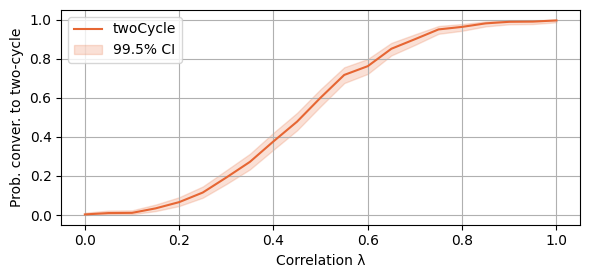

In [31]:
plot_single_algorithm(alg_name="SBRD", varName="S4_twoCycles", title="", mean_name="twoCycle", ylabel="Prob. conver. to two-cycle", axis=1, binomial=True, legend_loc="upper left")

And now the number of steps to convergence, with a 2SE range.

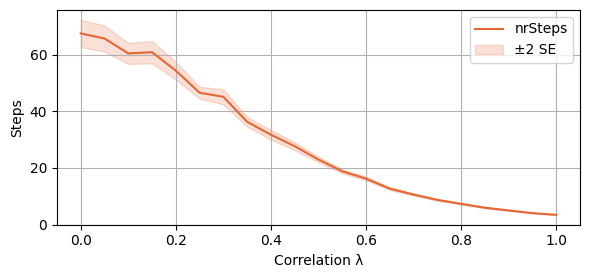

In [32]:
plot_single_algorithm(alg_name="SBRD", varName="S4_nrSteps", mean_name="nrSteps", title="", ylabel="Steps", axis=1, isPositive=True, log=False, legend_loc="upper right")

And, as before, the threshold values of lambda. Notice that now SBRD converges to a two-cycle with 90% probability for all the values of lambda over 0.75.

In [33]:
print(round(lambda_vals[int(np.argmax(np.mean(SBRD_S4_twoCycles, axis=-1)>0.5))],2))
print(round(lambda_vals[int(np.argmax(np.mean(SBRD_S4_twoCycles, axis=-1)>0.9))],2))

0.5
0.75


## Section B.1. Results of Section 2. also hold for more actions

We now show that what we showed in Section 1. still holds for more actions.
Setting of the experiment:
- 1000 independent simulations
- Each simulation takes lambda in a range of values between 0 and 1
- The number of actions is set to 100
- The number of players is set to three

Statistics analysed:
- SBRD_S5_isNash[l, 0, t]: True if the t-th test with the l-th value of lambda converges to a NE
- SBRD_S5_nrSteps[l, 0, t]: number of steps to convergence (or cycle) of the t-th test with the l-th value of lambda

In [34]:
# Number of simulations per (λ, N) setting
samples = 1000
lambda_vals = [0.09999999999*0.5*i for i in range(21)]
A_vals = [100]

SBRD_S5_isNash = np.full((len(lambda_vals), 1, samples), False, dtype=bool)
SBRD_S5_nrSteps = np.zeros((len(lambda_vals), len(A_vals), samples))

In [35]:
np.random.seed(2025) #We set the random seed for reproducibility 
T_0 = time()  # Start timer for entire experiment
max_A = max(A_vals)
for count_lam, lam in enumerate(lambda_vals):  # Loop over each lambda value
    for i in range(samples):  # Repeat experiment for statistical robustness
        G = generate_reward_matrix(3, max_A, lam)  # Generate a payoff matrix with max_n actions and correlation lambda
    
        for count_A, A in enumerate(A_vals):  # Now restrict to smaller N if needed
            # Run Best Response Dynamics and time it
            SBRD_len, SBRD_it, SBRD_val_curr = best_response_dynamics(G, A)
            SBRD_S5_isNash[count_lam, count_A, i] = (SBRD_len == 1)
            SBRD_S5_nrSteps[count_lam, count_A, i] = SBRD_it

# Final time report
Total_time = time() - T_0
print(Total_time)

853.8707270622253


As before, we print the probability of SBRD to converge to a NE

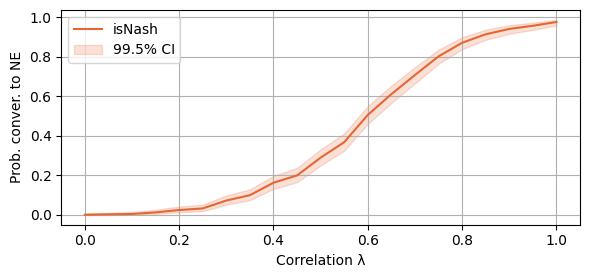

In [36]:
plot_single_algorithm(alg_name="SBRD", varName="S5_isNash", title="", mean_name="isNash", ylabel="Prob. conver. to NE", axis=1, binomial=True, legend_loc="upper left")

And then the average number of steps to convergence

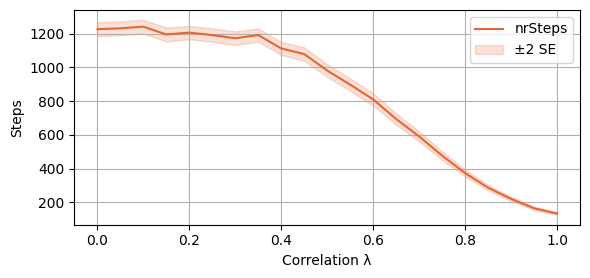

In [37]:
plot_single_algorithm(alg_name="SBRD", varName="S5_nrSteps", mean_name="nrSteps", title="", ylabel="Steps", axis=1, isPositive=True, log=False, legend_loc="upper right")

## Section B.2. Results of Section 2. also hold for more players

We now test SBRD for 4 players. 
Setting of the experiment:
- 1000 independent simulations
- Each simulation takes lambda in a range of values between 0 and 1
- The number of actions is set to 50
- The number of players is set to four

Statistics analysed:
- SBRD_S6_isNash[l, 0, t]: True if the t-th test with the l-th value of lambda converges to a NE
- SBRD_S6_nrSteps[l, 0, t]: number of steps to convergence (or cycle) of the t-th test with the l-th value of lambda

In [38]:
# Number of simulations per (λ, N) setting
samples = 1_000
lambda_vals = [0.09999999999*0.5*i for i in range(21)]
A_vals = [50]

SBRD_S6_isNash = np.full((len(lambda_vals), 1, samples), False, dtype=bool)
SBRD_S6_nrSteps = np.zeros((len(lambda_vals), len(A_vals), samples))

In [39]:
np.random.seed(2025) #We set the random seed for reproducibility 
T_0 = time()  # Start timer for entire experiment
max_A = max(A_vals)
for count_lam, lam in enumerate(lambda_vals):  # Loop over each lambda value
    for i in range(samples):  # Repeat experiment for statistical robustness
        G = generate_reward_matrix(4, max_A, lam)  # Generate a payoff matrix with max_n actions and correlation lambda
    
        for count_A, A in enumerate(A_vals):  # Now restrict to smaller N if needed
            # Run Best Response Dynamics and time it
            SBRD_len, SBRD_it, SBRD_val_curr = best_response_dynamics(G, A)
            SBRD_S6_isNash[count_lam, count_A, i] = (SBRD_len == 1)
            SBRD_S6_nrSteps[count_lam, count_A, i] = SBRD_it

# Final time report
Total_time = time() - T_0
print(Total_time)

25260.329627752304


We see that the probability of convergence to a NE follows the same pattern as above. We plot, as before, a confidence interval of 99.5% Clopper-Pearson.

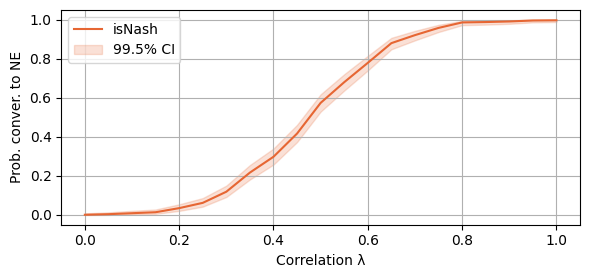

In [40]:
plot_single_algorithm(alg_name="SBRD", varName="S6_isNash", title="", mean_name="isNash", ylabel="Prob. conver. to NE", axis=1, binomial=True, legend_loc="upper left")

We also plot the average number of steps taken to convergence

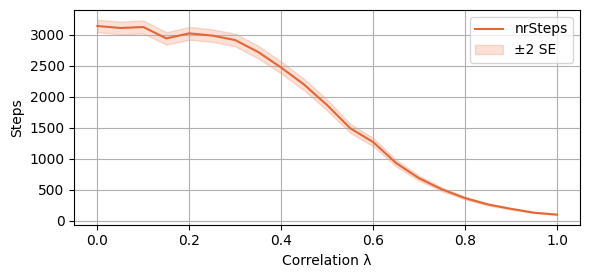

In [41]:
plot_single_algorithm(alg_name="SBRD", varName="S6_nrSteps", mean_name="nrSteps", title="", ylabel="Steps", axis=1, isPositive=True, log=False, legend_loc="upper right")

## Section C.1. Results of Section 3. also hold for more actions

Finally, we compare SBRD and SPGD over more actions to show that the behaviour is similar. 
Setting of the experiment:
- 1000 independent simulations
- Each simulation takes lambda in a range of values between 0.85 and 1
- The number of actions is set to 100
- The number of players is set to three

Statistics analysed:
- For SPGD:
    - PGD_S7_isNash[l, 0, t]: True if for the t-th test with the l-th value of lambda, SPGD converges to a NE
    - PGD_S7_numIte[l, 0, t]: number of steps to convergence (or cycle) for SPGD of the t-th test with the l-th value of lambda
    - PGD_S7_valFin[l, 0, t]: final payoff reached by SBPD in the t-th test with l-th value of lambda
    - PGD_S7_valAvg[l, 0, t]: average payoff during the trajectory of SBPD in the t-th test with the l-th value of lambda
    - PGD_S7_time[l, 0, t]: time to run SBPD in the t-th test with l-th value of lambda. 
        - Remark: SPGD is automatically stopped at the first check-point after 10 seconds run.
- for SBRD:
    - SBRD_S7_isNash[l, 0, t]: True if for the t-th test with the l-th value of lambda, SBRD converges to a NE
    - SBRD_S7_numIte[l, 0, t]: number of steps to convergence (or cycle) for SBRD of the t-th test with the l-th value of lambda
    - SBRD_S7_val[l, 0, t]: NE payoff reached by SBRD in the t-th test with l-th value of lambda if SBRD converges to a NE, or average payoff along the cycle if SBRD converges to a cycle.
    - SBRD_S7_time[l, 0, t]: time to run SBRD in the t-th test with l-th value of lambda.  

In [42]:
# Experimental setup
samples = 1000
lambda_vals = [0.85+0.09999999999*0.25*i for i in range(7)] # List of lambda values to test
A_vals = [100]

# Outputs to Track
## Policy Gradient Dynamics
PGD_S7_isNash = np.full((len(lambda_vals), len(A_vals), samples), False, dtype=bool) # {0,1} veridicity of Nash in Policy Gradient Dynamics
PGD_S7_numIte = np.zeros((len(lambda_vals), len(A_vals), samples)) # Number of iterations in Policy Gradient Dynamics
PGD_S7_valFin = np.zeros((len(lambda_vals), len(A_vals), samples)) # Final payoff for player 0 in Policy Gradient Dynamics
PGD_S7_valAvg = np.zeros((len(lambda_vals), len(A_vals), samples)) # Average payoff for player 0 in Policy Gradient Dynamics
PGD_S7_time = np.zeros((len(lambda_vals), len(A_vals), samples))   # Runtime in Policy Gradient Dynamics

## Best Response Dynamics
SBRD_S7_isNash = np.full((len(lambda_vals), len(A_vals), samples), False, dtype=bool) # {0,1} veridicity of Nash in Best Response Dynamics
SBRD_S7_numIte = np.zeros((len(lambda_vals), len(A_vals), samples)) # Number of iterations in Best Response Dynamics
SBRD_S7_val = np.zeros((len(lambda_vals), len(A_vals), samples)) # Final payoff for player 0 in Best Response Dynamics
SBRD_S7_time = np.zeros((len(lambda_vals), len(A_vals), samples))   # Runtime in Best Response Dynamics

In [43]:
max_A = A_vals[-1]  # Maximum number of actions (fixed at 50)
np.random.seed(2025) #We set the random seed for reproducibility 

T_0 = time()  # Start the global timer

for count_lam, lam in enumerate(lambda_vals):  # Loop over correlation values
    for i in range(samples):  # Loop over sample repetitions
        # Generate a shared reward matrix for both algorithms
        G = generate_reward_matrix(3, max_A, lam)

        for count_A, A in enumerate(A_vals):  # Loop over population sizes (fixed here)
            t_0 = time()  # Start timer for PGD
            PGD_it, PGD_avg_val, PGD_val = gradient_ascent_dynamics(G, A)
            t = time() - t_0  # Elapsed time

            PGD_S7_isNash[count_lam, count_A, i] = (PGD_it < 50_000 - 1)  # Converged?
            PGD_S7_numIte[count_lam, count_A, i] = PGD_it
            PGD_S7_valFin[count_lam, count_A, i] = PGD_val
            PGD_S7_valAvg[count_lam, count_A, i] = PGD_avg_val
            PGD_S7_time[count_lam, count_A, i] = t

            # === Best Response Dynamics (SBRD) ===
            t_0 = time()  # Start timer for SBRD
            SBRD_len, SBRD_it, SBRD_val_curr = best_response_dynamics(G, A)
            t = time() - t_0  # Elapsed time

            # Store SBRD results
            SBRD_S7_isNash[count_lam, count_A, i] = (SBRD_len == 1)  # Converged to pure NE?
            SBRD_S7_numIte[count_lam, count_A, i] = SBRD_it
            SBRD_S7_val[count_lam, count_A, i] = SBRD_val_curr
            SBRD_S7_time[count_lam, count_A, i] = t

# === Time Summary ===
Tot_time = time() - T_0
Tot_time_SBRD = np.sum(SBRD_S7_time)
Tot_time_PGD = np.sum(PGD_S7_time)
Tot_time_gener = Tot_time - Tot_time_SBRD - Tot_time_PGD

# Print runtime breakdown
print(f"Total time to run: {round(Tot_time, 1)} s")
print(f"Percentage of the time spent on random generation of matrix: {round((Tot_time_gener / Tot_time) * 100, 1)}%")
print(f"Percentage of the time spent on SBRD algorithm: {round((Tot_time_SBRD / Tot_time) * 100, 1)}%")
print(f"Percentage of the time spent on PGD algorithm: {round((Tot_time_PGD / Tot_time) * 100, 1)}%")


Total time to run: 21041.3 s
Percentage of the time spent on random generation of matrix: 1.2%
Percentage of the time spent on SBRD algorithm: 0.0%
Percentage of the time spent on PGD algorithm: 98.7%


As before, we see that SBRD takes less that 0.1% of the total running time. The largest proportion of the time is taken by SPGD. As before, SPGD is stopped at the first checkpoint after 10 seconds if convergence is not reached by then.

We first plot the average time as before. Notice that the scale is logarithmic!

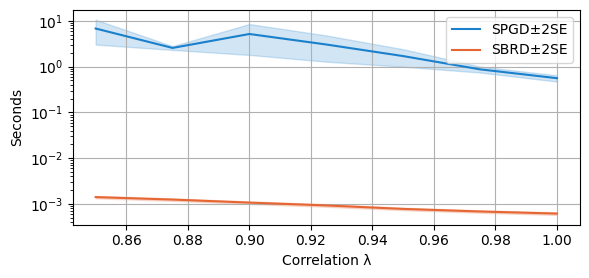

In [44]:
compare_algorithms(PGD_varName="S7_time", SBRD_varName="S7_time", title="", mean_1_name="SPGD±2SE", expnr="7", mean_2_name="SBRD±2SE", yLabel="Seconds", axis=1, variance=True, isPositive=True, log=True, legend_loc="upper right")

We now plot the average value of equilibria attained by the two algorithms. As mentioned above, they both converge with high probability, therefore these values have statistical significance.

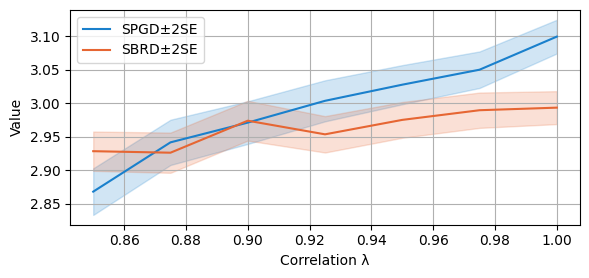

In [45]:
compare_algorithms(PGD_varName="S7_valFin", SBRD_varName="S7_val", title="", expnr="7", mean_1_name="SPGD±2SE", mean_2_name="SBRD±2SE", yLabel="Value", axis=1, variance=True, isPositive=True, only_if_conv=True, legend_loc="upper left")

We plot the average number of steps to convergence (to a NE or to a cycle)

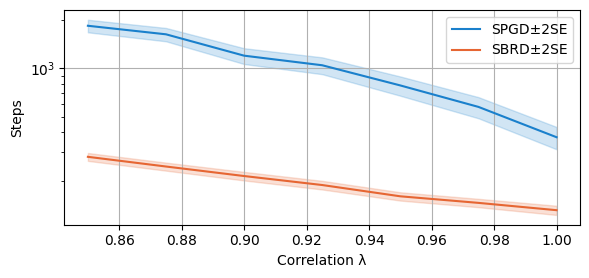

In [46]:
compare_algorithms(PGD_varName="S7_numIte", SBRD_varName="S7_numIte", title="", mean_1_name="SPGD±2SE",expnr="7", mean_2_name="SBRD±2SE", yLabel="Steps", axis=1, variance=True, isPositive=True, log=True, legend_loc="upper right")

And finally, as before we compare the average final value (equilibrium or not) of SBRD against the average value attained by SPGD in its trajectory.

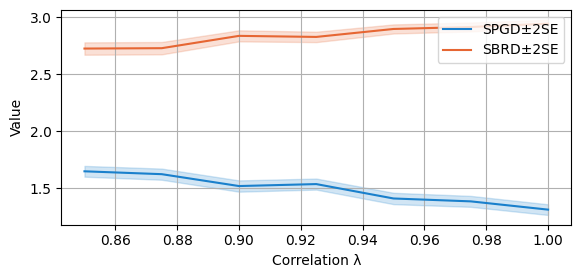

In [47]:
compare_algorithms(PGD_varName="S7_valAvg", SBRD_varName="S7_val", title="", expnr="7", mean_1_name="SPGD±2SE", mean_2_name="SBRD±2SE", yLabel="Value", axis=1, variance=True, isPositive=True, legend_loc="upper right")